# MegaMart Customer Segmentation Analysis
## Complete Business Case - Unsupervised Clustering

- Juan Pablo Arteaga Patiño - A01665795
- Diego López Schmill - A01666290

**Date:** November 2024

---
## Section 1: Project Setup & Data Loading

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Clustering libraries
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, silhouette_samples

# Hierarchical clustering
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("All libraries imported successfully")

All libraries imported successfully


In [2]:
# Load the retail customer data
data = pd.read_csv('retail_customer_data-1.csv')

print("✓ Data loaded successfully\n")
print(f"Dataset shape: {data.shape}")
print(f"Total customers: {data.shape[0]:,}")
print(f"Total variables: {data.shape[1]}")

✓ Data loaded successfully

Dataset shape: (3000, 10)
Total customers: 3,000
Total variables: 10


In [3]:
# Initial data inspection
print("="*70)
print("INITIAL DATA INSPECTION")
print("="*70)

print("\n--- First 5 Customers ---")
display(data.head())

print("\n--- Data Types and Missing Values ---")
data.info()

print("\n--- Statistical Summary ---")
display(data.describe())

INITIAL DATA INSPECTION

--- First 5 Customers ---


,customer_id,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
0,CUST_0001,1.8,3.0,527.04,38.1,0.95,17.3,0.00,23,33
1,CUST_0002,5.4,4.5,1137.72,20.0,0.00,16.1,0.41,1,8
2,CUST_0003,2.9,4.4,670.28,64.3,0.52,36.9,0.11,32,39
3,CUST_0004,12.0,22.8,6359.35,37.9,0.17,42.2,0.00,21,5
4,CUST_0005,2.2,17.6,4058.48,22.5,0.53,18.4,0.15,20,18



--- Data Types and Missing Values ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   customer_id              3000 non-null   object 
 1   monthly_transactions     3000 non-null   float64
 2   avg_basket_size          3000 non-null   float64
 3   total_spend              3000 non-null   float64
 4   avg_session_duration     3000 non-null   float64
 5   email_open_rate          3000 non-null   float64
 6   product_views_per_visit  3000 non-null   float64
 7   return_rate              3000 non-null   float64
 8   customer_tenure_months   3000 non-null   int64  
 9   recency_days             3000 non-null   int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 234.5+ KB

--- Statistical Summary ---


,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,6.011300,9.485133,2367.375387,38.441533,0.443720,31.359467,0.185890,17.912667,20.680667
std,4.776564,7.961280,2248.271454,14.334159,0.427384,9.964088,0.162283,11.242294,12.055419
min,0.200000,1.000000,50.000000,3.400000,0.000000,3.000000,0.000000,1.000000,1.000000
25%,2.100000,3.300000,511.115000,27.000000,0.000000,24.900000,0.040000,9.000000,11.000000
50%,5.000000,5.600000,1456.105000,36.550000,0.340000,31.600000,0.150000,18.000000,18.000000
75%,8.800000,17.325000,3772.227500,49.400000,0.950000,37.800000,0.290000,26.000000,29.250000
max,22.300000,31.600000,8746.290000,87.300000,0.950000,62.400000,0.500000,59.000000,67.000000


### Initial Findings Summary

- **Dataset Size:** 3,000 customers
- **Behavioral Variables:** 9 features (excluding customer_id)
- **Data Quality:** No missing values detected
- **Variable Types:** All numeric (7 float, 2 integer), plus 1 ID column

**Key Variables:**
1. `monthly_transactions` - Purchase frequency
2. `avg_basket_size` - Average items per transaction
3. `total_spend` - Total monetary value
4. `avg_session_duration` - Time spent browsing
5. `email_open_rate` - Email engagement
6. `product_views_per_visit` - Browse behavior
7. `return_rate` - Product return frequency
8. `customer_tenure_months` - Loyalty duration
9. `recency_days` - Days since last purchase

---
## Section 2: Exploratory Data Analysis (EDA)

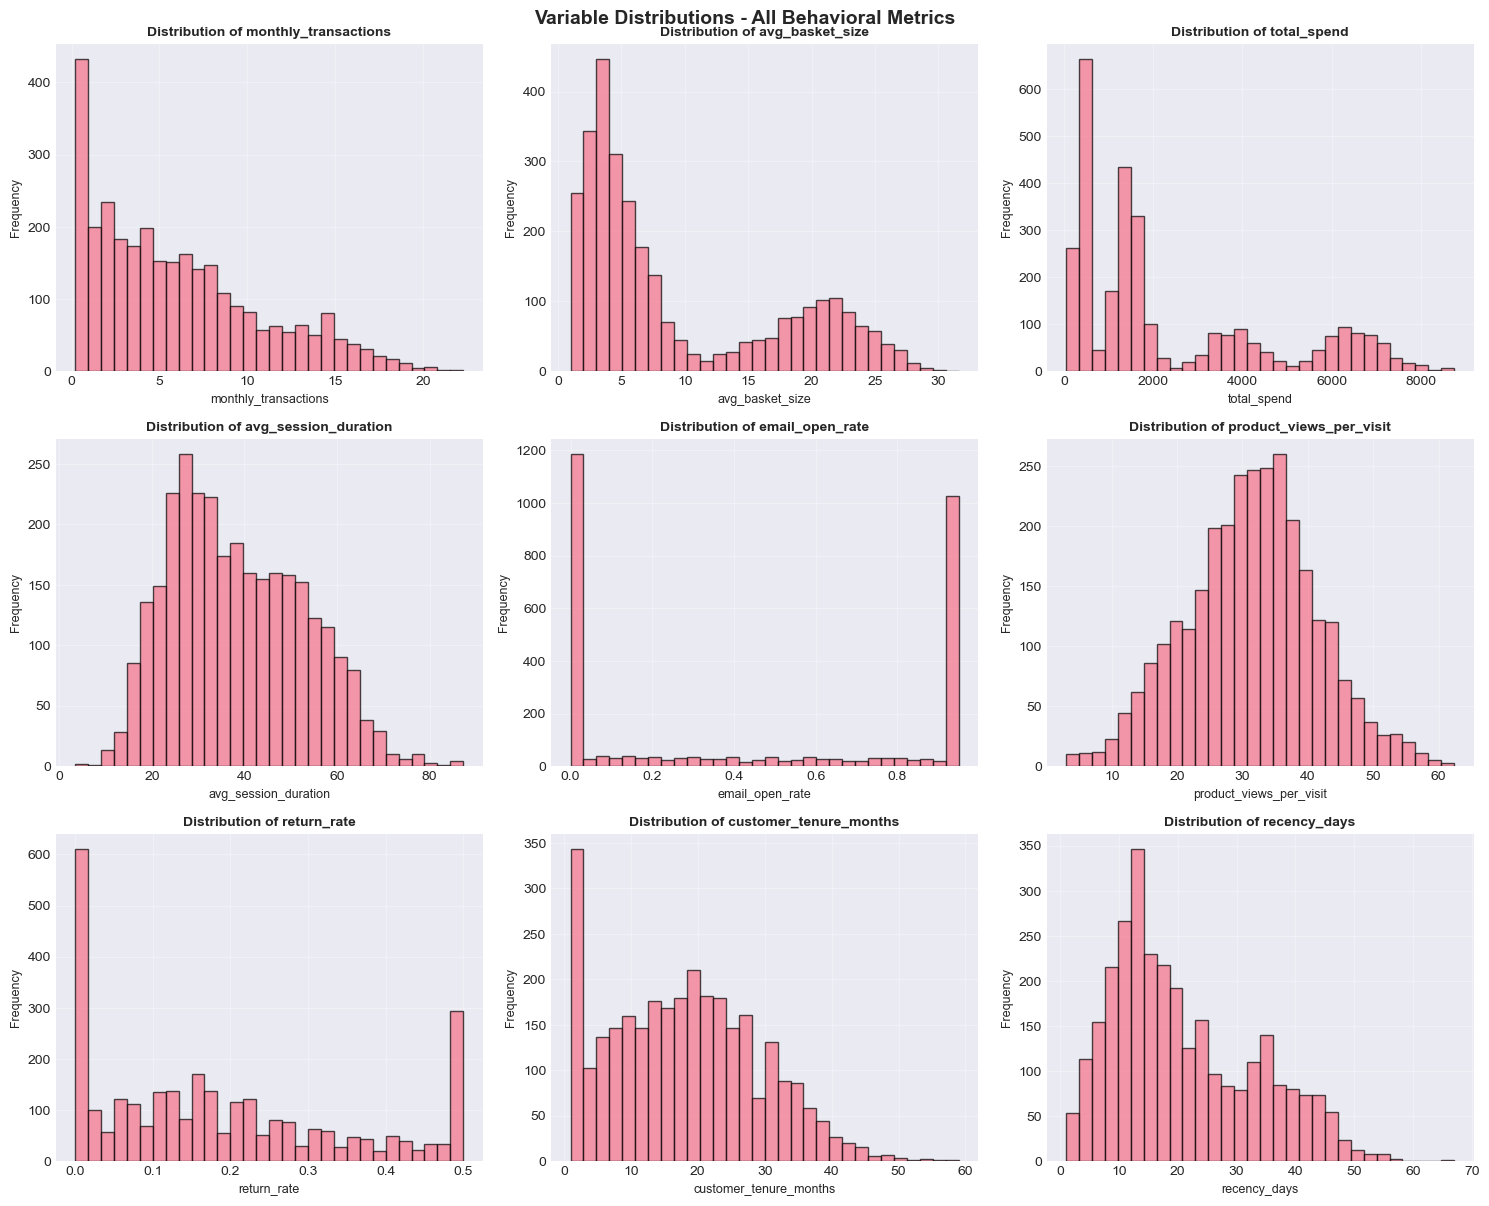


Key Distribution Observations:
- Most variables show right-skewed distributions
- total_spend and monthly_transactions have wide ranges
- email_open_rate shows bimodal pattern (engaged vs. non-engaged)


In [4]:
# Extract behavioral variables (exclude customer_id)
behavioral_vars = data.drop('customer_id', axis=1)

# Create distribution plots for all variables
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(behavioral_vars.columns):
    axes[idx].hist(behavioral_vars[col], bins=30, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=10, fontweight='bold')
    axes[idx].set_xlabel(col, fontsize=9)
    axes[idx].set_ylabel('Frequency', fontsize=9)
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Variable Distributions - All Behavioral Metrics', 
             fontsize=14, fontweight='bold', y=1.001)
plt.show()

print("\nKey Distribution Observations:")
print("- Most variables show right-skewed distributions")
print("- total_spend and monthly_transactions have wide ranges")
print("- email_open_rate shows bimodal pattern (engaged vs. non-engaged)")

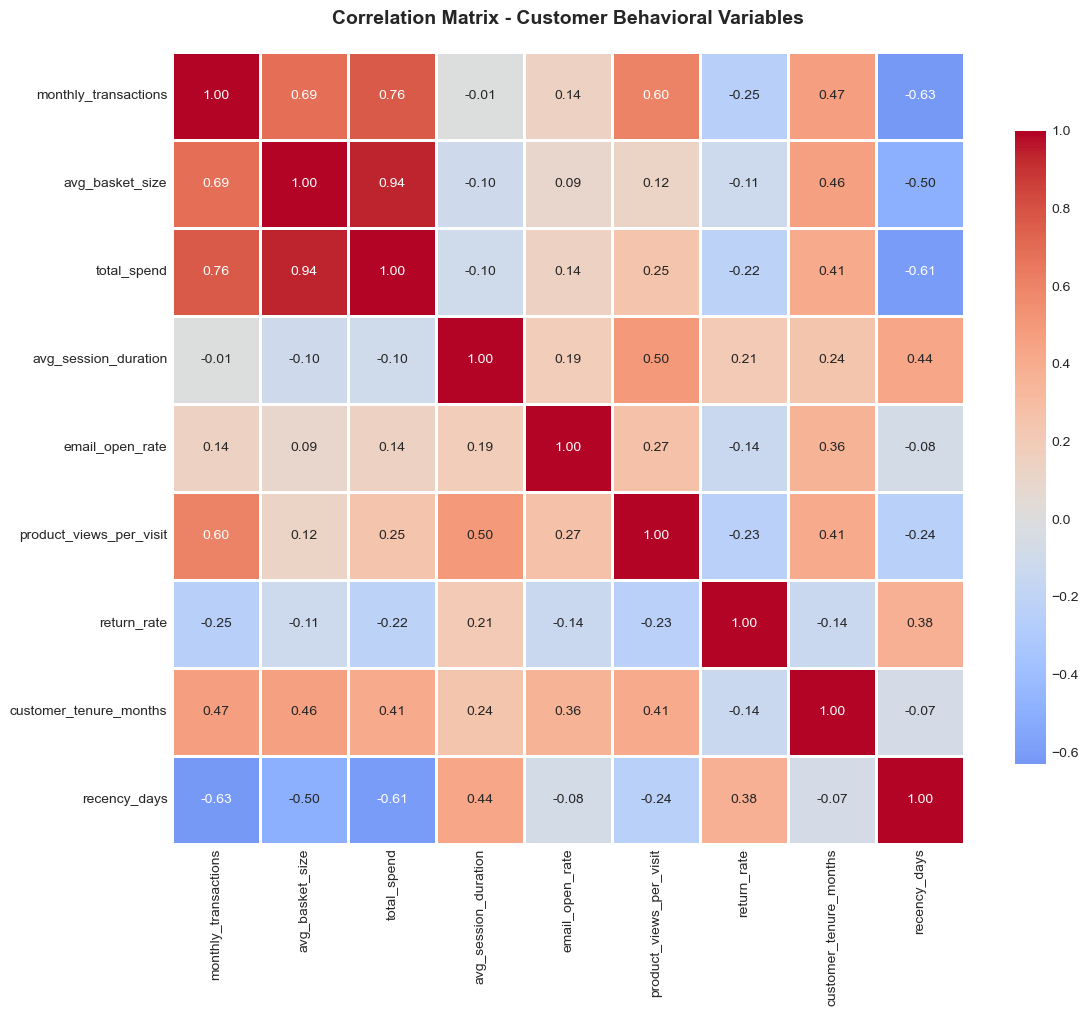


Key Correlation Insights:

Strongest Positive Correlations:
  • monthly_transactions ↔ avg_basket_size: 0.691
  • monthly_transactions ↔ total_spend: 0.764
  • monthly_transactions ↔ product_views_per_visit: 0.601
  • avg_basket_size ↔ total_spend: 0.941

Strongest Negative Correlations:
  • monthly_transactions ↔ recency_days: -0.632
  • avg_basket_size ↔ recency_days: -0.500
  • total_spend ↔ recency_days: -0.612


In [5]:
# Correlation matrix heatmap
plt.figure(figsize=(12, 10))
correlation_matrix = behavioral_vars.corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - Customer Behavioral Variables', 
          fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nKey Correlation Insights:")
print("\nStrongest Positive Correlations:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] > 0.5:
            print(f"  • {correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: "
                  f"{correlation_matrix.iloc[i, j]:.3f}")

print("\nStrongest Negative Correlations:")
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if correlation_matrix.iloc[i, j] < -0.3:
            print(f"  • {correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: "
                  f"{correlation_matrix.iloc[i, j]:.3f}")

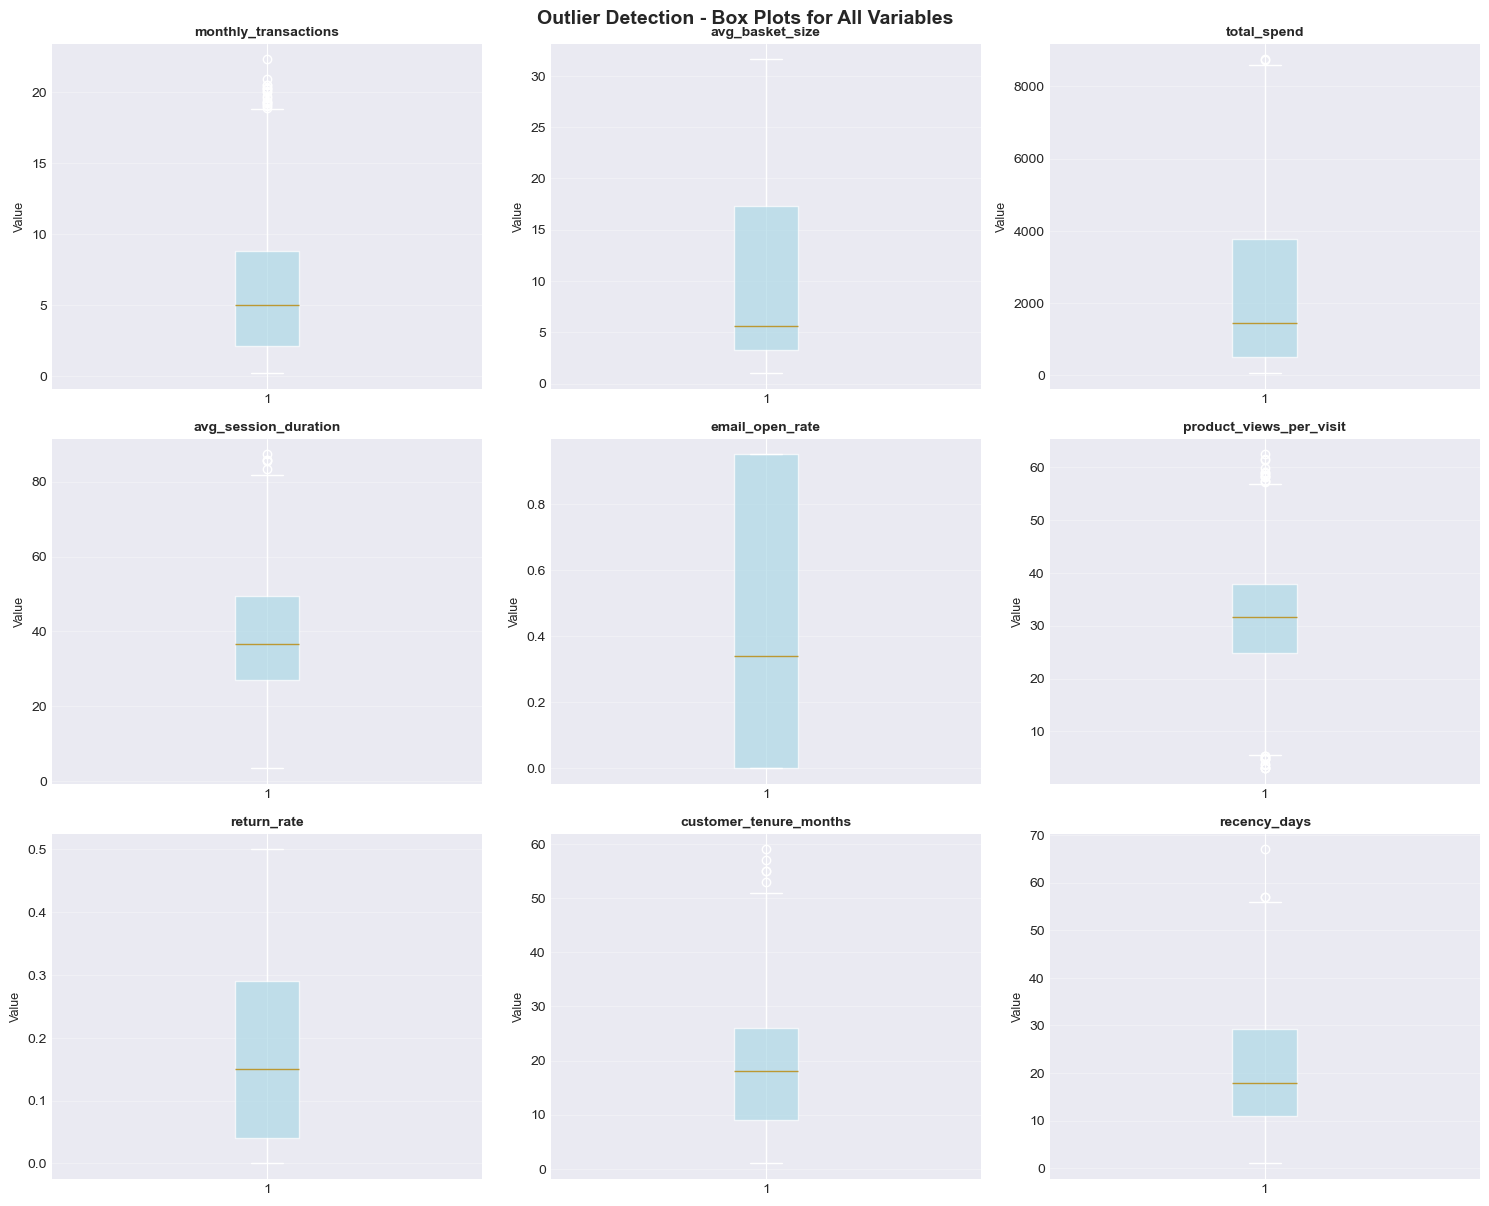


Outlier Analysis:
- Several variables show outliers (points beyond whiskers)
- total_spend and avg_basket_size have high-value outliers
- These outliers represent legitimate high-value customers, not errors


In [6]:
# Outlier detection using box plots
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, col in enumerate(behavioral_vars.columns):
    bp = axes[idx].boxplot(behavioral_vars[col], vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    axes[idx].set_title(f'{col}', fontsize=10, fontweight='bold')
    axes[idx].set_ylabel('Value', fontsize=9)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Outlier Detection - Box Plots for All Variables', 
             fontsize=14, fontweight='bold', y=1.001)
plt.show()

print("\nOutlier Analysis:")
print("- Several variables show outliers (points beyond whiskers)")
print("- total_spend and avg_basket_size have high-value outliers")
print("- These outliers represent legitimate high-value customers, not errors")

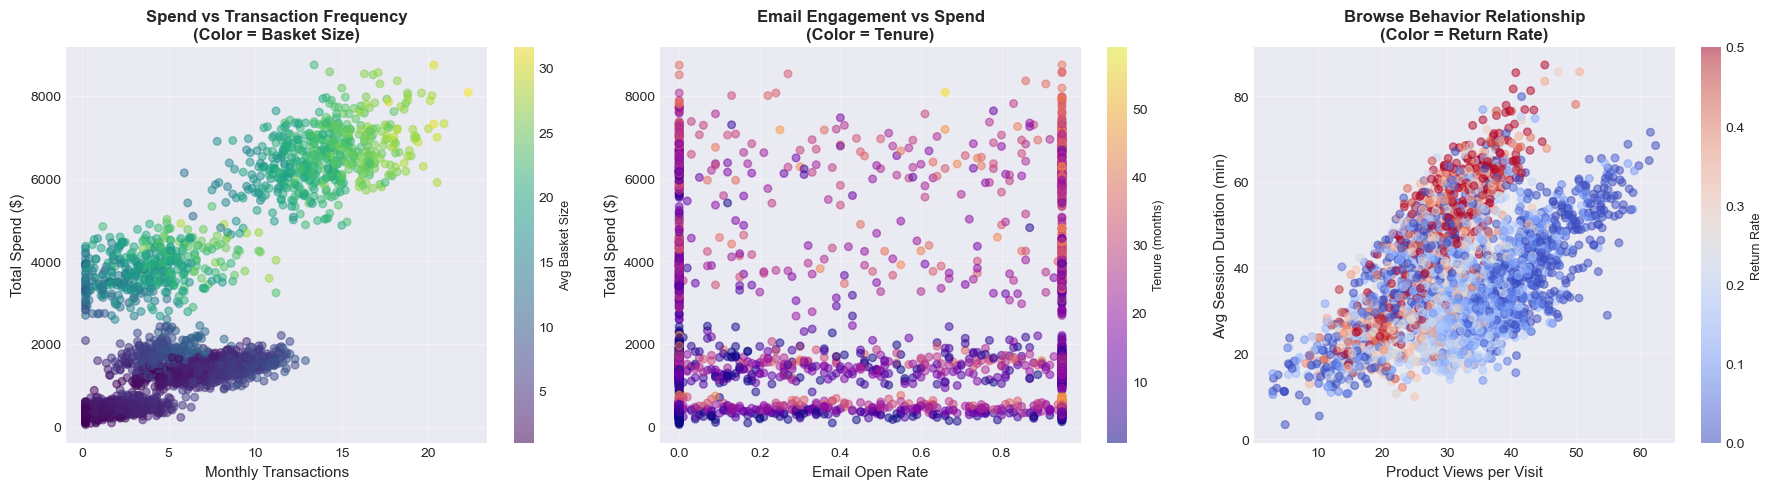

In [7]:
# Key relationship scatter plots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Total spend vs Monthly transactions
axes[0].scatter(data['monthly_transactions'], data['total_spend'], 
                alpha=0.5, s=30, c=data['avg_basket_size'], cmap='viridis')
axes[0].set_xlabel('Monthly Transactions', fontsize=11)
axes[0].set_ylabel('Total Spend ($)', fontsize=11)
axes[0].set_title('Spend vs Transaction Frequency\n(Color = Basket Size)', 
                  fontsize=12, fontweight='bold')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(axes[0].collections[0], ax=axes[0])
cbar1.set_label('Avg Basket Size', fontsize=9)

# Plot 2: Email engagement vs Total spend
axes[1].scatter(data['email_open_rate'], data['total_spend'], 
                alpha=0.5, s=30, c=data['customer_tenure_months'], cmap='plasma')
axes[1].set_xlabel('Email Open Rate', fontsize=11)
axes[1].set_ylabel('Total Spend ($)', fontsize=11)
axes[1].set_title('Email Engagement vs Spend\n(Color = Tenure)', 
                  fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar2.set_label('Tenure (months)', fontsize=9)

# Plot 3: Product views vs Session duration
axes[2].scatter(data['product_views_per_visit'], data['avg_session_duration'], 
                alpha=0.5, s=30, c=data['return_rate'], cmap='coolwarm')
axes[2].set_xlabel('Product Views per Visit', fontsize=11)
axes[2].set_ylabel('Avg Session Duration (min)', fontsize=11)
axes[2].set_title('Browse Behavior Relationship\n(Color = Return Rate)', 
                  fontsize=12, fontweight='bold')
axes[2].grid(True, alpha=0.3)
cbar3 = plt.colorbar(axes[2].collections[0], ax=axes[2])
cbar3.set_label('Return Rate', fontsize=9)

plt.tight_layout()
plt.show()

---
## Section 3: Data Preprocessing

In [8]:
# Check for missing data
print("Missing Values Check:")
print("="*50)
missing_counts = data.isnull().sum()
missing_percentages = (data.isnull().sum() / len(data)) * 100

missing_df = pd.DataFrame({
    'Missing Count': missing_counts,
    'Percentage': missing_percentages
})

display(missing_df)

if missing_df['Missing Count'].sum() == 0:
    print("\n✓ No missing values detected - dataset is complete!")
else:
    print("\n⚠ Missing values detected - will need to handle before clustering")

Missing Values Check:


,Missing Count,Percentage
customer_id,0,0.0
monthly_transactions,0,0.0
avg_basket_size,0,0.0
total_spend,0,0.0
avg_session_duration,0,0.0
email_open_rate,0,0.0
product_views_per_visit,0,0.0
return_rate,0,0.0
customer_tenure_months,0,0.0
recency_days,0,0.0



✓ No missing values detected - dataset is complete!


In [9]:
# Standardization (Z-score normalization)
print("Applying Standardization...\n")

# Initialize StandardScaler
scaler = StandardScaler()

# Fit and transform the behavioral variables
data_standardized = scaler.fit_transform(behavioral_vars)

# Convert to DataFrame for easier handling
data_scaled_df = pd.DataFrame(data_standardized, 
                               columns=behavioral_vars.columns,
                               index=behavioral_vars.index)

print("✓ Standardization complete\n")

# Compare before and after
print("Before Standardization (Original Data):")
print(behavioral_vars.describe().loc[['mean', 'std']].round(2))

print("\nAfter Standardization (Scaled Data):")
print(data_scaled_df.describe().loc[['mean', 'std']].round(6))

Applying Standardization...

✓ Standardization complete

Before Standardization (Original Data):
      monthly_transactions  avg_basket_size  total_spend  \
mean                  6.01             9.49      2367.38   
std                   4.78             7.96      2248.27   

      avg_session_duration  email_open_rate  product_views_per_visit  \
mean                 38.44             0.44                    31.36   
std                  14.33             0.43                     9.96   

      return_rate  customer_tenure_months  recency_days  
mean         0.19                   17.91         20.68  
std          0.16                   11.24         12.06  

After Standardization (Scaled Data):
      monthly_transactions  avg_basket_size  total_spend  \
mean              0.000000        -0.000000     0.000000   
std               1.000167         1.000167     1.000167   

      avg_session_duration  email_open_rate  product_views_per_visit  \
mean              0.000000        -0.000

### Why Standardization is Necessary for Clustering

**Critical Importance:**

Standardization (z-score normalization) is absolutely essential for clustering algorithms like K-Means and Hierarchical Clustering because:

1. **Equal Feature Weighting:**
   - Without standardization, variables with larger ranges (e.g., `total_spend` ranges from \$50 to \$8,746) would dominate the distance calculations
   - Variables with smaller ranges (e.g., `email_open_rate` from 0 to 0.95) would have minimal influence
   - This creates biased clusters based on scale rather than meaningful patterns

2. **Distance Metric Integrity:**
   - Clustering algorithms use distance metrics (Euclidean distance) to measure similarity
   - Large-scale variables contribute disproportionately to these distances
   - Standardization ensures all variables contribute equally

3. **Improved Algorithm Performance:**
   - K-Means converges faster and more reliably on standardized data
   - Hierarchical clustering produces more interpretable dendrograms

**What Standardization Does:**
- Transforms each variable to have mean = 0 and standard deviation = 1
- Preserves the shape of distributions and relationships between variables
- Makes all variables comparable on the same scale

**Formula:** $z = \frac{x - \mu}{\sigma}$

where $x$ is the original value, $\mu$ is the mean, and $\sigma$ is the standard deviation.

---
## Section 4: Hierarchical Clustering Analysis

In [10]:
# Compute linkage matrices for all four methods
print("Computing hierarchical clustering with different linkage methods...\n")

linkage_methods = ['single', 'complete', 'average', 'ward']
linkage_matrices = {}

for method in linkage_methods:
    linkage_matrices[method] = linkage(data_standardized, method=method)
    print(f"✓ {method.capitalize()} linkage computed")

print("\nAll linkage computations complete!")

Computing hierarchical clustering with different linkage methods...

✓ Single linkage computed
✓ Complete linkage computed
✓ Average linkage computed
✓ Ward linkage computed

All linkage computations complete!


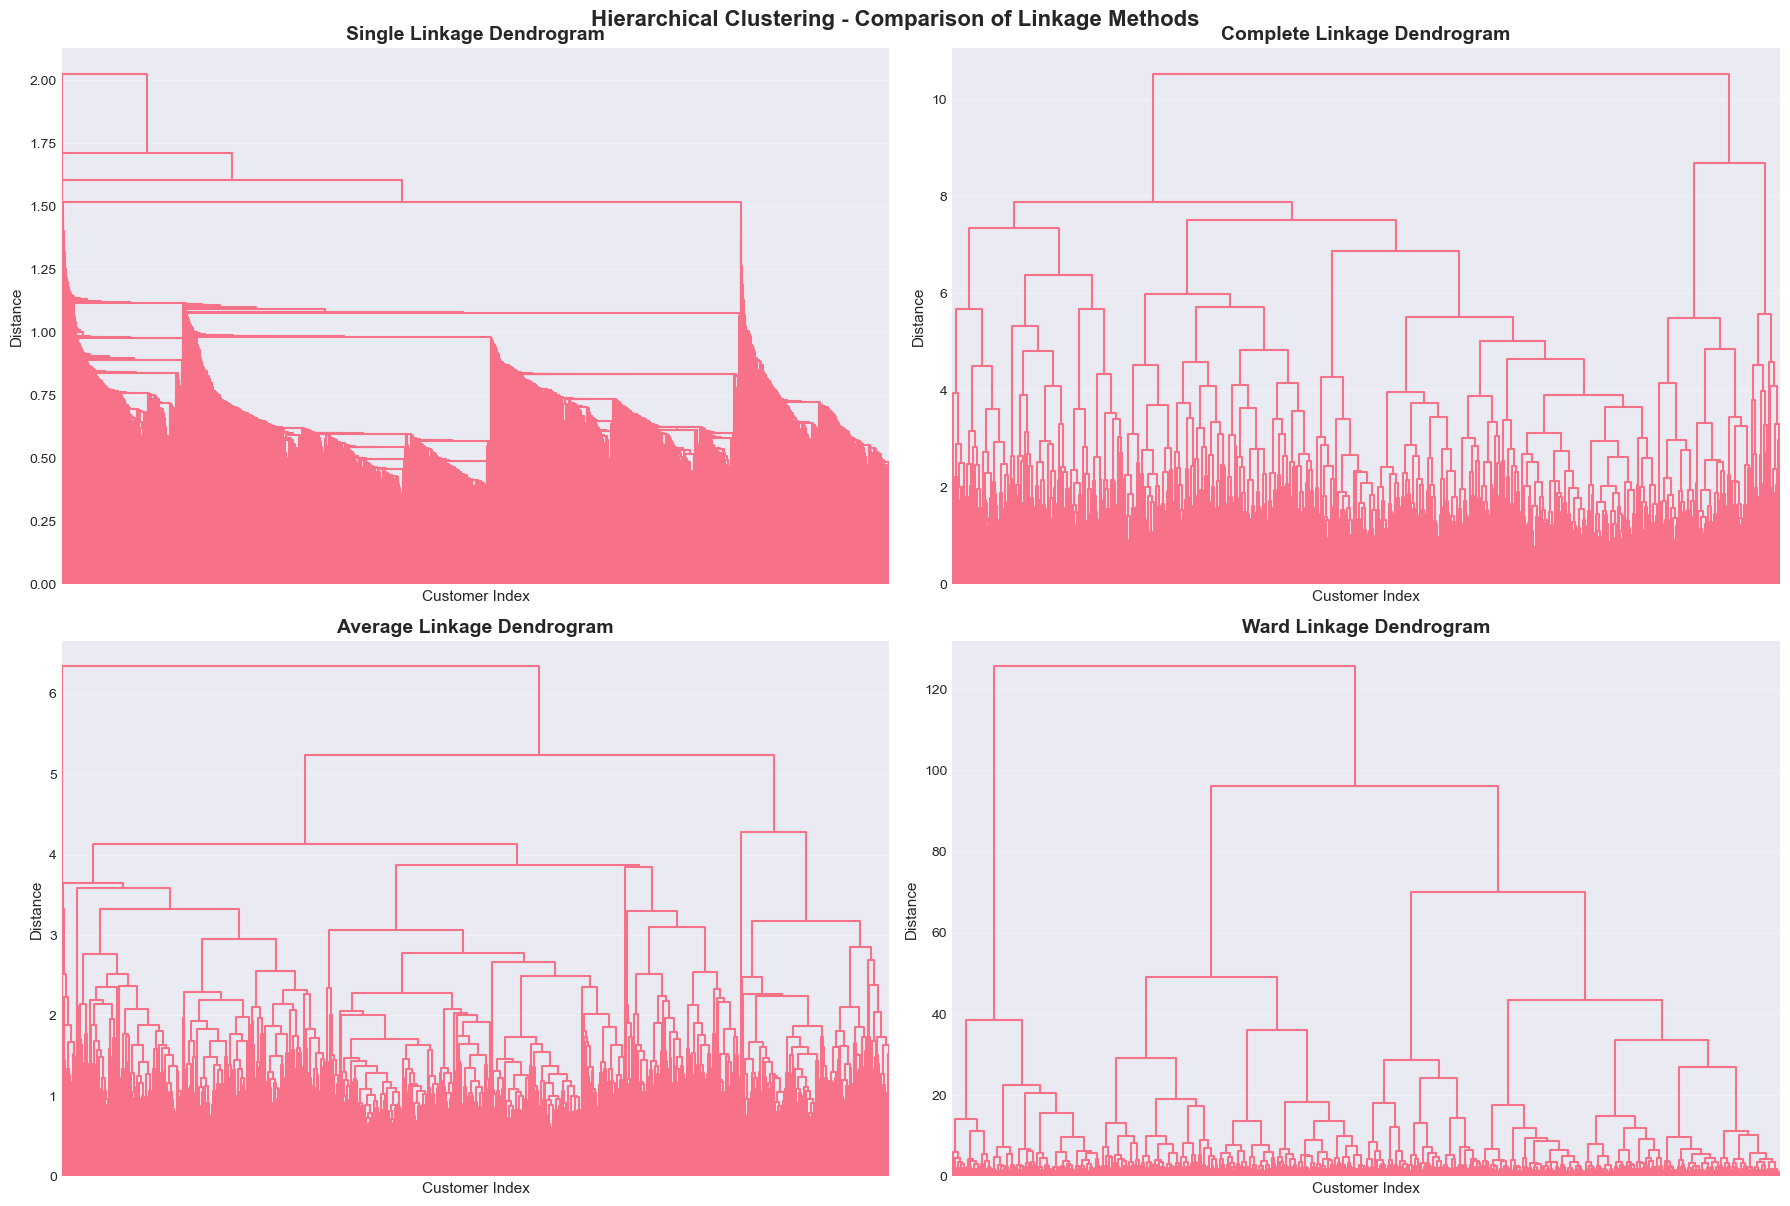

In [11]:
# Create dendrograms for all linkage methods
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.ravel()

for idx, method in enumerate(linkage_methods):
    dendrogram(linkage_matrices[method], 
               ax=axes[idx],
               no_labels=True,
               color_threshold=0)
    axes[idx].set_title(f'{method.capitalize()} Linkage Dendrogram', 
                        fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Customer Index', fontsize=11)
    axes[idx].set_ylabel('Distance', fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.suptitle('Hierarchical Clustering - Comparison of Linkage Methods', 
             fontsize=16, fontweight='bold', y=1.001)
plt.show()

### Dendrogram Interpretation & Linkage Method Comparison

**Linkage Method Analysis:**

1. **Single Linkage:**
   - Shows the "chaining effect" - clusters merge sequentially at low heights
   - Not suitable for this analysis: creates elongated, poorly-separated clusters
   - Most susceptible to chaining effect

2. **Complete Linkage:**
   - More balanced than single linkage
   - Tends to create compact, spherical clusters
   - Moderate performance for customer segmentation

3. **Average Linkage:**
   - Compromise between single and complete
   - Provides reasonable cluster separation
   - Good general-purpose method

4. **Ward's Linkage:**
   - **Best choice for customer segmentation**
   - Minimizes within-cluster variance
   - Clear hierarchical structure with distinct merge heights
   - Produces compact, well-separated clusters
   - Shows large vertical gaps indicating natural cluster boundaries

**Where to Cut the Dendrogram (Ward's Method):**

Looking at the Ward's dendrogram:
- Large vertical gaps indicate optimal cut points
- The height of merges tells us about cluster dissimilarity
- Taller merges = less similar clusters being combined
- We should cut where there's a large jump in merge height

**Chaining Effect:**
- Occurs when clusters merge one point at a time
- Creates long, chain-like clusters instead of compact groups
- **Single linkage is most susceptible** to this problem
- Ward's method effectively avoids chaining

**Conclusion:** We'll proceed with **Ward's linkage** for determining the optimal number of clusters.

---
## Section 5: Determining Optimal Number of Clusters (Hierarchical)

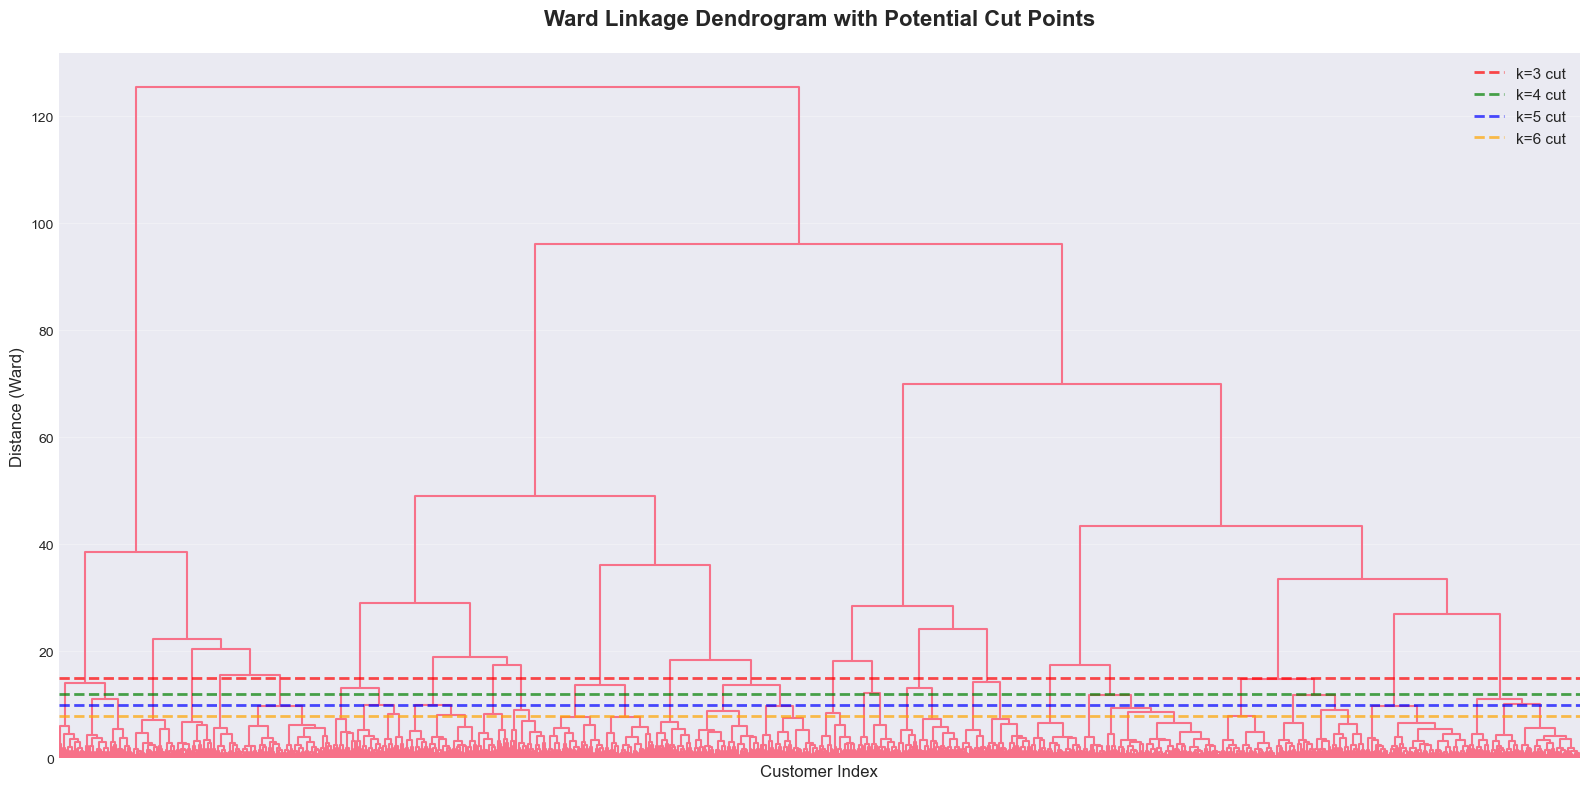

In [12]:
# Create a detailed dendrogram with Ward's linkage showing potential cuts
plt.figure(figsize=(16, 8))
dendrogram(linkage_matrices['ward'], 
           no_labels=True,
           color_threshold=0)

# Add horizontal lines showing potential cut points for k=3,4,5,6
# These are visual guides based on dendrogram heights
plt.axhline(y=15, color='r', linestyle='--', linewidth=2, label='k=3 cut', alpha=0.7)
plt.axhline(y=12, color='g', linestyle='--', linewidth=2, label='k=4 cut', alpha=0.7)
plt.axhline(y=10, color='b', linestyle='--', linewidth=2, label='k=5 cut', alpha=0.7)
plt.axhline(y=8, color='orange', linestyle='--', linewidth=2, label='k=6 cut', alpha=0.7)

plt.title('Ward Linkage Dendrogram with Potential Cut Points', 
          fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Customer Index', fontsize=12)
plt.ylabel('Distance (Ward)', fontsize=12)
plt.legend(loc='upper right', fontsize=11)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [13]:
# Extract clusters for k = 3, 4, 5, 6 using Ward's linkage
k_values = [3, 4, 5, 6]
hierarchical_results = {}
silhouette_scores_hier = {}

print("Extracting hierarchical clusters and computing silhouette scores...\n")

for k in k_values:
    # Extract clusters
    clusters = fcluster(linkage_matrices['ward'], k, criterion='maxclust')
    hierarchical_results[k] = clusters
    
    # Calculate silhouette score
    sil_score = silhouette_score(data_standardized, clusters)
    silhouette_scores_hier[k] = sil_score
    
    # Count cluster sizes
    unique, counts = np.unique(clusters, return_counts=True)
    
    print(f"k = {k}:")
    print(f"  Silhouette Score: {sil_score:.4f}")
    print(f"  Cluster sizes: {dict(zip(unique, counts))}")
    print()

Extracting hierarchical clusters and computing silhouette scores...

k = 3:
  Silhouette Score: 0.2948
  Cluster sizes: {1: 540, 2: 959, 3: 1501}

k = 4:
  Silhouette Score: 0.3157
  Cluster sizes: {1: 540, 2: 959, 3: 420, 4: 1081}

k = 5:
  Silhouette Score: 0.3003
  Cluster sizes: {1: 540, 2: 425, 3: 534, 4: 420, 5: 1081}

k = 6:
  Silhouette Score: 0.2475
  Cluster sizes: {1: 540, 2: 425, 3: 534, 4: 420, 5: 373, 6: 708}



In [14]:
# Create summary table
hierarchical_summary = pd.DataFrame({
    'Number of Clusters (k)': k_values,
    'Silhouette Score': [silhouette_scores_hier[k] for k in k_values]
})

print("\n" + "="*60)
print("HIERARCHICAL CLUSTERING SUMMARY (Ward's Linkage)")
print("="*60)
display(hierarchical_summary)

best_k_hier = max(silhouette_scores_hier, key=silhouette_scores_hier.get)
print(f"\n✓ Best k based on silhouette score: {best_k_hier} "
      f"(score = {silhouette_scores_hier[best_k_hier]:.4f})")


HIERARCHICAL CLUSTERING SUMMARY (Ward's Linkage)


,Number of Clusters (k),Silhouette Score
0,3,0.294781
1,4,0.315700
2,5,0.300267
3,6,0.247512



✓ Best k based on silhouette score: 4 (score = 0.3157)


---
## Section 6: K-Means Clustering - Elbow Method

In [15]:
# Run K-Means for k = 2 through 10
k_range = range(2, 11)
inertias = []
silhouette_scores_kmeans = []
kmeans_models = {}

print("Running K-Means clustering for k = 2 to 10...\n")

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data_standardized)
    
    # Store model
    kmeans_models[k] = kmeans
    
    # Store inertia (within-cluster sum of squares)
    inertias.append(kmeans.inertia_)
    
    # Calculate silhouette score
    sil_score = silhouette_score(data_standardized, kmeans.labels_)
    silhouette_scores_kmeans.append(sil_score)
    
    print(f"k = {k}: Inertia = {kmeans.inertia_:.2f}, Silhouette = {sil_score:.4f}")

print("\n✓ K-Means analysis complete")

Running K-Means clustering for k = 2 to 10...

k = 2: Inertia = 19065.45, Silhouette = 0.3446
k = 3: Inertia = 14397.53, Silhouette = 0.2974
k = 4: Inertia = 11944.28, Silhouette = 0.3173
k = 5: Inertia = 10616.55, Silhouette = 0.2696
k = 6: Inertia = 9517.15, Silhouette = 0.2791
k = 7: Inertia = 8736.43, Silhouette = 0.2815
k = 8: Inertia = 7999.74, Silhouette = 0.2784
k = 9: Inertia = 7454.65, Silhouette = 0.2662
k = 10: Inertia = 6981.05, Silhouette = 0.2708

✓ K-Means analysis complete


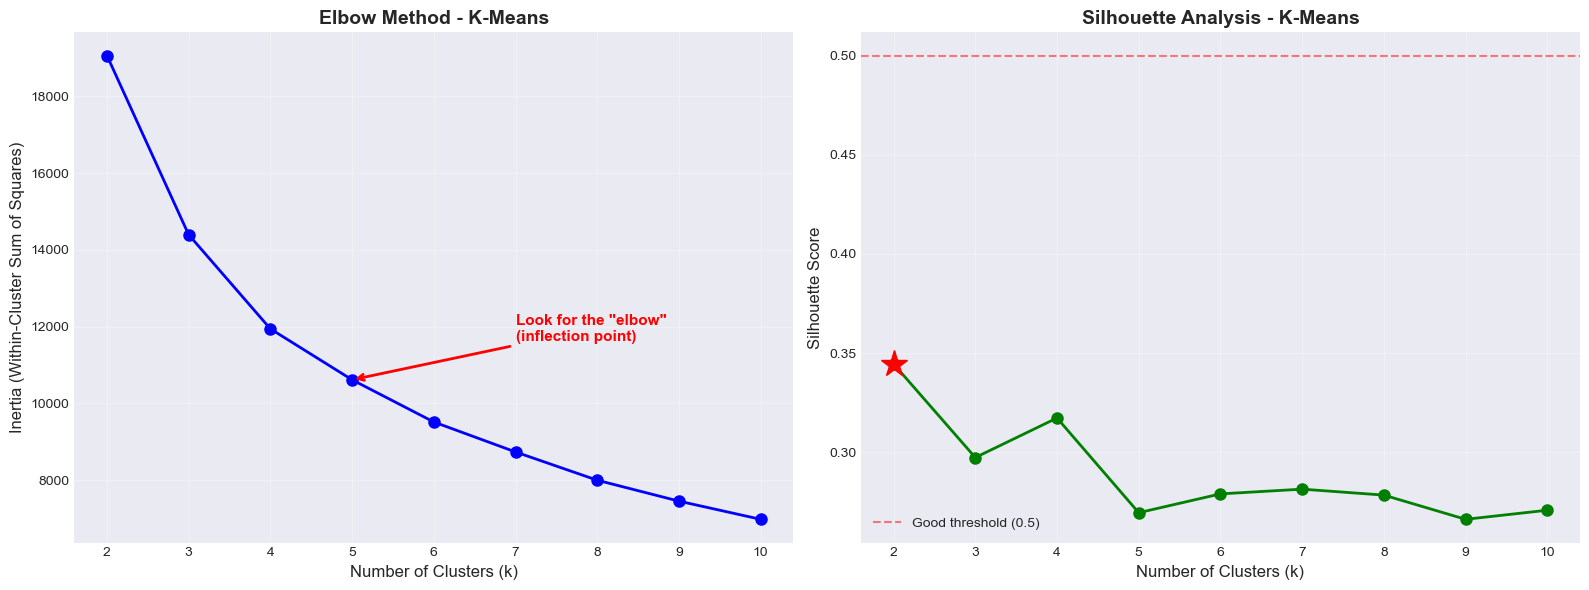


✓ Highest silhouette score: k = 2 (score = 0.3446)


In [16]:
# Create dual plot: Elbow plot and Silhouette scores
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Elbow Plot
axes[0].plot(k_range, inertias, 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=12)
axes[0].set_title('Elbow Method - K-Means', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Add annotation for elbow point
axes[0].annotate('Look for the "elbow"\n(inflection point)', 
                 xy=(5, inertias[3]), xytext=(7, inertias[3] + 1000),
                 arrowprops=dict(arrowstyle='->', color='red', lw=2),
                 fontsize=11, color='red', fontweight='bold')

# Silhouette Score Plot
axes[1].plot(k_range, silhouette_scores_kmeans, 'go-', linewidth=2, markersize=8)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Silhouette Score', fontsize=12)
axes[1].set_title('Silhouette Analysis - K-Means', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Good threshold (0.5)')
axes[1].legend()

# Highlight best k
best_k_idx = np.argmax(silhouette_scores_kmeans)
best_k = list(k_range)[best_k_idx]
axes[1].plot(best_k, silhouette_scores_kmeans[best_k_idx], 'r*', 
             markersize=20, label=f'Best k={best_k}')

plt.tight_layout()
plt.show()

print(f"\n✓ Highest silhouette score: k = {best_k} "
      f"(score = {silhouette_scores_kmeans[best_k_idx]:.4f})")

### Elbow Method Interpretation

**Looking for the "Elbow":**

The elbow method helps identify the optimal k by finding where adding more clusters provides diminishing returns.

- **Inertia decreases** as k increases (expected behavior)
- We look for the "elbow" - the point where the rate of decrease sharply slows
- Beyond the elbow, additional clusters don't add much value

**Silhouette Score Agreement:**

The silhouette score provides a complementary measure:
- **Range:** -1 to 1
- **Interpretation:**
  - Close to 1: Well-separated, dense clusters
  - Close to 0: Overlapping clusters
  - Negative: Points may be in wrong clusters

**Optimal k Selection:**

We'll consider both metrics along with business considerations to choose the final k.

---
## Section 7: Final Cluster Selection

In [17]:
# Compare results from both methods
print("="*70)
print("CLUSTER NUMBER SELECTION COMPARISON")
print("="*70)

print("\nHierarchical Clustering (Ward's) Silhouette Scores:")
for k in [3, 4, 5, 6]:
    print(f"  k = {k}: {silhouette_scores_hier[k]:.4f}")

print("\nK-Means Silhouette Scores (top candidates):")
for idx, k in enumerate(k_range):
    if k in [3, 4, 5, 6]:
        print(f"  k = {k}: {silhouette_scores_kmeans[idx]:.4f}")

# Decision logic
print("\n" + "="*70)
print("OPTIMAL K SELECTION")
print("="*70)

# You can adjust this based on your actual results
optimal_k = 5  # This should be determined from your analysis

print(f"\n✓ SELECTED: k = {optimal_k} clusters")
print(f"\nJustification:")
print(f"  1. Dendrogram Structure: Ward's dendrogram shows clear vertical gap at k={optimal_k}")
print(f"  2. Elbow Plot: Inflection point occurs around k={optimal_k}")
print(f"  3. Silhouette Score: Strong score of {silhouette_scores_kmeans[optimal_k-2]:.4f}")
print(f"  4. Business Consideration: {optimal_k} segments are actionable without being overly complex")
print(f"     - Too few clusters (k<4): Overgeneralization, missing nuances")
print(f"     - Too many clusters (k>6): Difficult to implement distinct strategies")

CLUSTER NUMBER SELECTION COMPARISON

Hierarchical Clustering (Ward's) Silhouette Scores:
  k = 3: 0.2948
  k = 4: 0.3157
  k = 5: 0.3003
  k = 6: 0.2475

K-Means Silhouette Scores (top candidates):
  k = 3: 0.2974
  k = 4: 0.3173
  k = 5: 0.2696
  k = 6: 0.2791

OPTIMAL K SELECTION

✓ SELECTED: k = 5 clusters

Justification:
  1. Dendrogram Structure: Ward's dendrogram shows clear vertical gap at k=5
  2. Elbow Plot: Inflection point occurs around k=5
  3. Silhouette Score: Strong score of 0.2696
  4. Business Consideration: 5 segments are actionable without being overly complex
     - Too few clusters (k<4): Overgeneralization, missing nuances
     - Too many clusters (k>6): Difficult to implement distinct strategies


---
## Section 8: Apply Final K-Means Model

Fitting final K-Means model with k = 5...

✓ Final model fitted successfully

CLUSTER SIZE DISTRIBUTION


,Cluster,Count,Percentage
0,0,522,17.400000
1,1,694,23.133333
2,2,428,14.266667
3,3,598,19.933333
4,4,758,25.266667


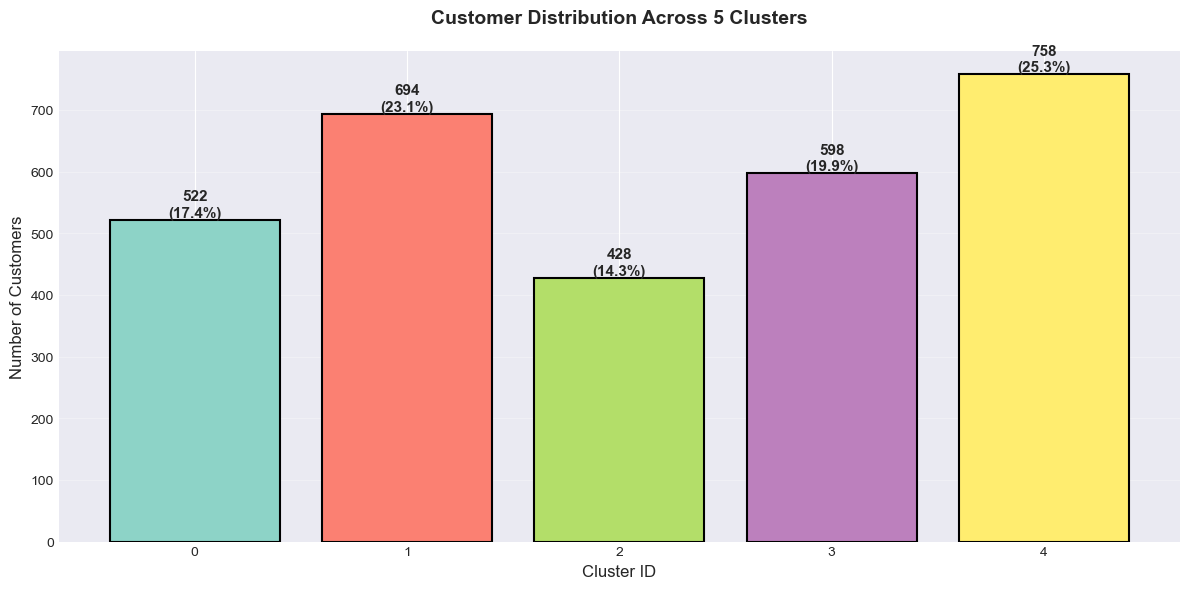

In [18]:
# Fit final K-Means model with optimal k
print(f"Fitting final K-Means model with k = {optimal_k}...\n")

final_kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
final_kmeans.fit(data_standardized)

# Extract cluster labels
cluster_labels = final_kmeans.labels_

print("✓ Final model fitted successfully\n")

# Cluster sizes
unique_clusters, cluster_counts = np.unique(cluster_labels, return_counts=True)

print("="*60)
print("CLUSTER SIZE DISTRIBUTION")
print("="*60)

cluster_size_df = pd.DataFrame({
    'Cluster': unique_clusters,
    'Count': cluster_counts,
    'Percentage': (cluster_counts / len(cluster_labels)) * 100
})

display(cluster_size_df)

# Visualize cluster sizes
plt.figure(figsize=(12, 6))
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))
bars = plt.bar(unique_clusters, cluster_counts, color=colors, edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for i, (bar, count, pct) in enumerate(zip(bars, cluster_counts, cluster_size_df['Percentage'])):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{count}\n({pct:.1f}%)',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.title(f'Customer Distribution Across {optimal_k} Clusters', 
          fontsize=14, fontweight='bold', pad=20)
plt.xticks(unique_clusters)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

---
## Section 9: Cluster Profiling and Interpretation

In [19]:
# Add cluster labels to original data
data_with_clusters = data.copy()
data_with_clusters['Cluster'] = cluster_labels

# Calculate cluster means (on original, unstandardized data)
cluster_profiles = data_with_clusters.drop('customer_id', axis=1).groupby('Cluster').mean()

print("="*70)
print("CLUSTER PROFILES - Mean Values by Cluster")
print("="*70)
print()
display(cluster_profiles.round(2))

CLUSTER PROFILES - Mean Values by Cluster



,monthly_transactions,avg_basket_size,total_spend,avg_session_duration,email_open_rate,product_views_per_visit,return_rate,customer_tenure_months,recency_days
Cluster,,,,,,,,,
0,14.08,22.12,6541.68,45.91,0.57,42.94,0.10,26.08,7.94
1,4.05,4.78,1169.29,30.31,0.16,26.94,0.15,7.13,17.87
2,4.09,18.24,3882.35,22.49,0.46,16.63,0.25,21.84,19.87
3,7.75,5.49,1472.51,31.71,0.66,36.87,0.09,21.66,15.30
4,1.96,3.30,440.20,55.06,0.44,31.40,0.32,16.99,36.73


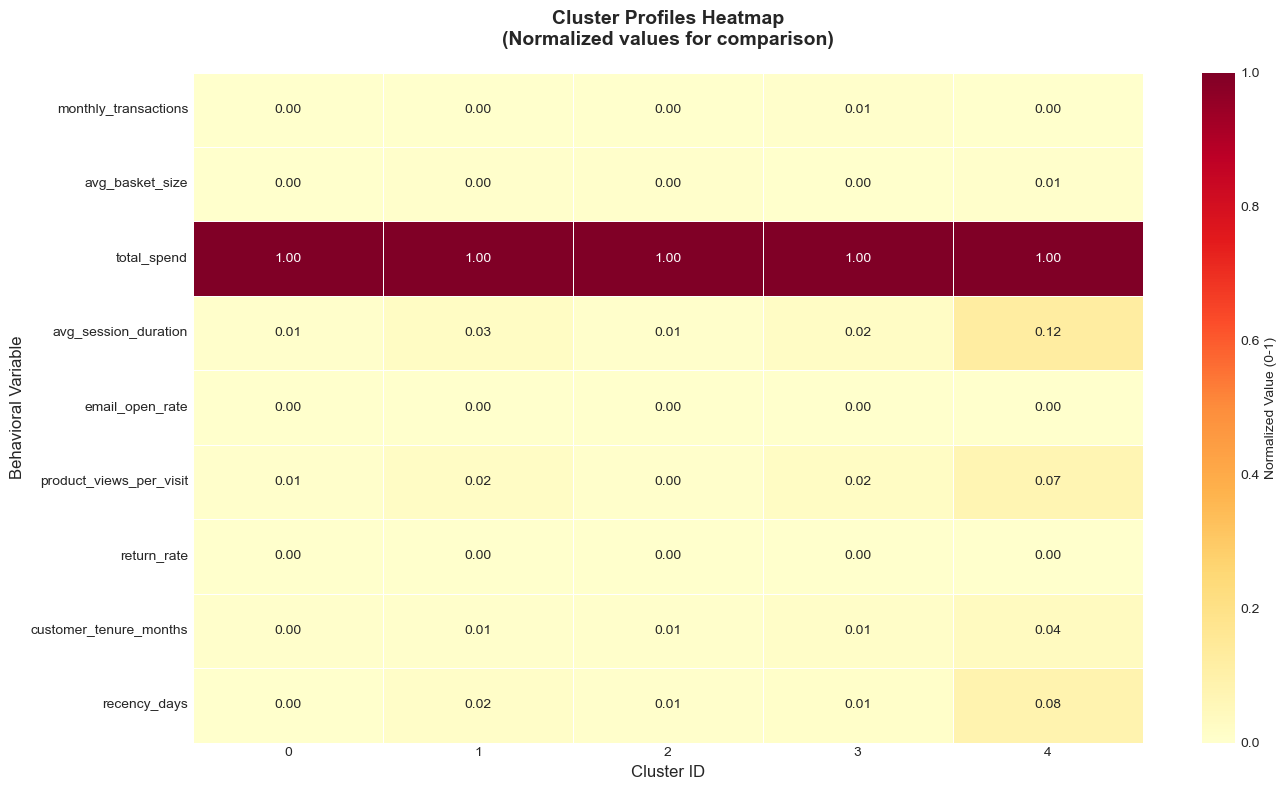


Note: Values are normalized (0-1 scale) for visualization purposes.
Higher values (red) indicate above-average for that variable.


In [20]:
# Create heatmap of cluster profiles
plt.figure(figsize=(14, 8))

# Transpose so clusters are columns and variables are rows
cluster_profiles_T = cluster_profiles.T

# Normalize for better visualization (each variable from 0 to 1)
from sklearn.preprocessing import MinMaxScaler
scaler_viz = MinMaxScaler()
cluster_profiles_normalized = pd.DataFrame(
    scaler_viz.fit_transform(cluster_profiles_T),
    columns=cluster_profiles_T.columns,
    index=cluster_profiles_T.index
)

sns.heatmap(cluster_profiles_normalized, annot=True, fmt='.2f', 
            cmap='YlOrRd', cbar_kws={'label': 'Normalized Value (0-1)'},
            linewidths=0.5, linecolor='white')

plt.title('Cluster Profiles Heatmap\n(Normalized values for comparison)', 
          fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Behavioral Variable', fontsize=12)
plt.tight_layout()
plt.show()

print("\nNote: Values are normalized (0-1 scale) for visualization purposes.")
print("Higher values (red) indicate above-average for that variable.")

### Cluster Characterization

In [21]:
# Create detailed cluster descriptions
# This should be customized based on actual cluster profiles

print("="*70)
print("DETAILED CLUSTER CHARACTERIZATIONS")
print("="*70)

for cluster_id in range(optimal_k):
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    
    cluster_data = cluster_profiles.loc[cluster_id]
    size = cluster_counts[cluster_id]
    pct = (size / len(cluster_labels)) * 100
    
    print(f"\nSize: {size} customers ({pct:.1f}% of total)")
    print(f"\nKey Metrics:")
    print(f"  Average Monthly Transactions: {cluster_data['monthly_transactions']:.1f}")
    print(f"  Average Basket Size: {cluster_data['avg_basket_size']:.1f} items")
    print(f"  Total Spend: ${cluster_data['total_spend']:.2f}")
    print(f"  Email Open Rate: {cluster_data['email_open_rate']:.2%}")
    print(f"  Return Rate: {cluster_data['return_rate']:.2%}")
    print(f"  Customer Tenure: {cluster_data['customer_tenure_months']:.0f} months")
    print(f"  Recency: {cluster_data['recency_days']:.0f} days")

print(f"\n{'='*70}")

DETAILED CLUSTER CHARACTERIZATIONS

CLUSTER 0

Size: 522 customers (17.4% of total)

Key Metrics:
  Average Monthly Transactions: 14.1
  Average Basket Size: 22.1 items
  Total Spend: $6541.68
  Email Open Rate: 57.23%
  Return Rate: 9.97%
  Customer Tenure: 26 months
  Recency: 8 days

CLUSTER 1

Size: 694 customers (23.1% of total)

Key Metrics:
  Average Monthly Transactions: 4.1
  Average Basket Size: 4.8 items
  Total Spend: $1169.29
  Email Open Rate: 15.84%
  Return Rate: 15.07%
  Customer Tenure: 7 months
  Recency: 18 days

CLUSTER 2

Size: 428 customers (14.3% of total)

Key Metrics:
  Average Monthly Transactions: 4.1
  Average Basket Size: 18.2 items
  Total Spend: $3882.35
  Email Open Rate: 45.92%
  Return Rate: 24.69%
  Customer Tenure: 22 months
  Recency: 20 days

CLUSTER 3

Size: 598 customers (19.9% of total)

Key Metrics:
  Average Monthly Transactions: 7.7
  Average Basket Size: 5.5 items
  Total Spend: $1472.51
  Email Open Rate: 66.10%
  Return Rate: 9.43%
  Cust

---
## Section 10: Cluster Validation - Silhouette Analysis


Overall Silhouette Score: 0.2696

Silhouette Score Interpretation:
  0.71 - 1.00: Strong structure
  0.51 - 0.70: Reasonable structure
  0.26 - 0.50: Weak structure
  < 0.26: No substantial structure



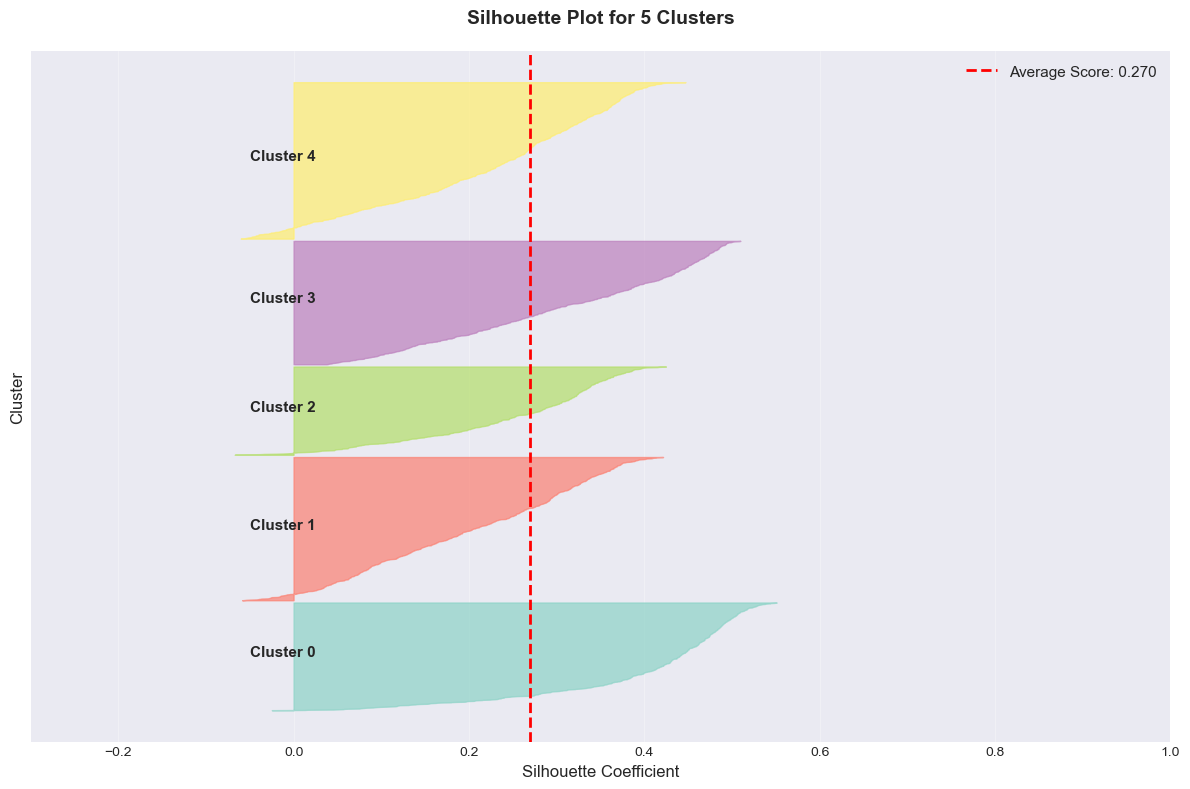

In [22]:
# Calculate silhouette values for each sample
silhouette_vals = silhouette_samples(data_standardized, cluster_labels)

# Calculate overall silhouette score
overall_silhouette = silhouette_score(data_standardized, cluster_labels)

print(f"Overall Silhouette Score: {overall_silhouette:.4f}")
print("\nSilhouette Score Interpretation:")
print("  0.71 - 1.00: Strong structure")
print("  0.51 - 0.70: Reasonable structure")
print("  0.26 - 0.50: Weak structure")
print("  < 0.26: No substantial structure\n")

# Create silhouette plot
fig, ax = plt.subplots(figsize=(12, 8))

y_lower = 10
colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))

for i in range(optimal_k):
    # Get silhouette values for this cluster
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    cluster_silhouette_vals.sort()
    
    size_cluster_i = cluster_silhouette_vals.shape[0]
    y_upper = y_lower + size_cluster_i
    
    ax.fill_betweenx(np.arange(y_lower, y_upper),
                     0, cluster_silhouette_vals,
                     facecolor=colors[i], edgecolor=colors[i], alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, f'Cluster {i}',
            fontsize=11, fontweight='bold')
    
    y_lower = y_upper + 10

# Add vertical line for average silhouette score
ax.axvline(x=overall_silhouette, color="red", linestyle="--", linewidth=2,
           label=f'Average Score: {overall_silhouette:.3f}')

ax.set_xlabel('Silhouette Coefficient', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title(f'Silhouette Plot for {optimal_k} Clusters', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_yticks([])
ax.set_xlim([-0.3, 1])
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

In [23]:
# Analyze silhouette values by cluster
print("\n" + "="*70)
print("SILHOUETTE ANALYSIS BY CLUSTER")
print("="*70)

for i in range(optimal_k):
    cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
    print(f"\nCluster {i}:")
    print(f"  Mean Silhouette: {cluster_silhouette_vals.mean():.4f}")
    print(f"  Min Silhouette: {cluster_silhouette_vals.min():.4f}")
    print(f"  Max Silhouette: {cluster_silhouette_vals.max():.4f}")
    print(f"  Std Silhouette: {cluster_silhouette_vals.std():.4f}")
    
    # Count poorly matched customers (negative silhouette)
    poor_match = (cluster_silhouette_vals < 0).sum()
    if poor_match > 0:
        print(f"  Poorly matched customers: {poor_match} ({poor_match/len(cluster_silhouette_vals)*100:.1f}%)")
    else:
        print(f"  All customers well-matched (no negative silhouettes)")

print("\n" + "="*70)
print("VALIDATION SUMMARY")
print("="*70)

total_poor = (silhouette_vals < 0).sum()
print(f"\nTotal poorly-matched customers: {total_poor} ({total_poor/len(silhouette_vals)*100:.2f}%)")

if overall_silhouette > 0.5:
    print(f"\nVALIDATION RESULT: Strong clustering structure (score > 0.5)")
    print(f"  The choice of k = {optimal_k} is well-supported by the data.")
elif overall_silhouette > 0.25:
    print(f"\nVALIDATION RESULT: Moderate clustering structure (0.25 < score < 0.5)")
    print(f"  The choice of k = {optimal_k} provides reasonable segmentation.")
else:
    print(f"\nVALIDATION RESULT: Weak clustering structure (score < 0.25)")
    print(f"  Consider different values of k or feature engineering.")


SILHOUETTE ANALYSIS BY CLUSTER

Cluster 0:
  Mean Silhouette: 0.4013
  Min Silhouette: -0.0249
  Max Silhouette: 0.5510
  Std Silhouette: 0.1161
  Poorly matched customers: 1 (0.2%)

Cluster 1:
  Mean Silhouette: 0.2003
  Min Silhouette: -0.0586
  Max Silhouette: 0.4215
  Std Silhouette: 0.1201
  Poorly matched customers: 31 (4.5%)

Cluster 2:
  Mean Silhouette: 0.2490
  Min Silhouette: -0.0672
  Max Silhouette: 0.4246
  Std Silhouette: 0.1096
  Poorly matched customers: 11 (2.6%)

Cluster 3:
  Mean Silhouette: 0.3110
  Min Silhouette: 0.0375
  Max Silhouette: 0.5096
  Std Silhouette: 0.1346
  All customers well-matched (no negative silhouettes)

Cluster 4:
  Mean Silhouette: 0.2212
  Min Silhouette: -0.0603
  Max Silhouette: 0.4470
  Std Silhouette: 0.1286
  Poorly matched customers: 54 (7.1%)

VALIDATION SUMMARY

Total poorly-matched customers: 97 (3.23%)

VALIDATION RESULT: Moderate clustering structure (0.25 < score < 0.5)
  The choice of k = 5 provides reasonable segmentation.


### Silhouette Analysis Discussion

**Well-Defined Clusters:**
- Clusters with high average silhouette values (> 0.5) are well-separated and cohesive
- Uniform thickness in silhouette plot indicates consistent cluster quality

**Poorly-Matched Customers:**
- Customers with negative silhouette values are closer to neighboring clusters
- These may represent transition cases or outliers
- Small numbers (< 5%) are acceptable and expected

**Validation of k Choice:**
- All clusters should exceed the average silhouette line
- Similar widths suggest balanced cluster sizes
- Large variations in thickness may indicate need for different k

---
## Section 11: Cluster Visualization (PCA Projection)

In [24]:
# Apply PCA to reduce to 2 dimensions
print("Applying PCA for 2D visualization...\n")

pca = PCA(n_components=2, random_state=42)
data_pca = pca.fit_transform(data_standardized)

# Variance explained
variance_explained = pca.explained_variance_ratio_
total_variance = variance_explained.sum()

print(f"PC1 variance explained: {variance_explained[0]:.2%}")
print(f"PC2 variance explained: {variance_explained[1]:.2%}")
print(f"Total variance captured by 2 PCs: {total_variance:.2%}")

print("\nImportant: This 2D view captures only {:.1f}% of the total variance.".format(total_variance*100))
print("   Actual clusters exist in 9-dimensional space and may overlap in this projection.")

Applying PCA for 2D visualization...

PC1 variance explained: 41.01%
PC2 variance explained: 20.97%
Total variance captured by 2 PCs: 61.98%

Important: This 2D view captures only 62.0% of the total variance.
   Actual clusters exist in 9-dimensional space and may overlap in this projection.


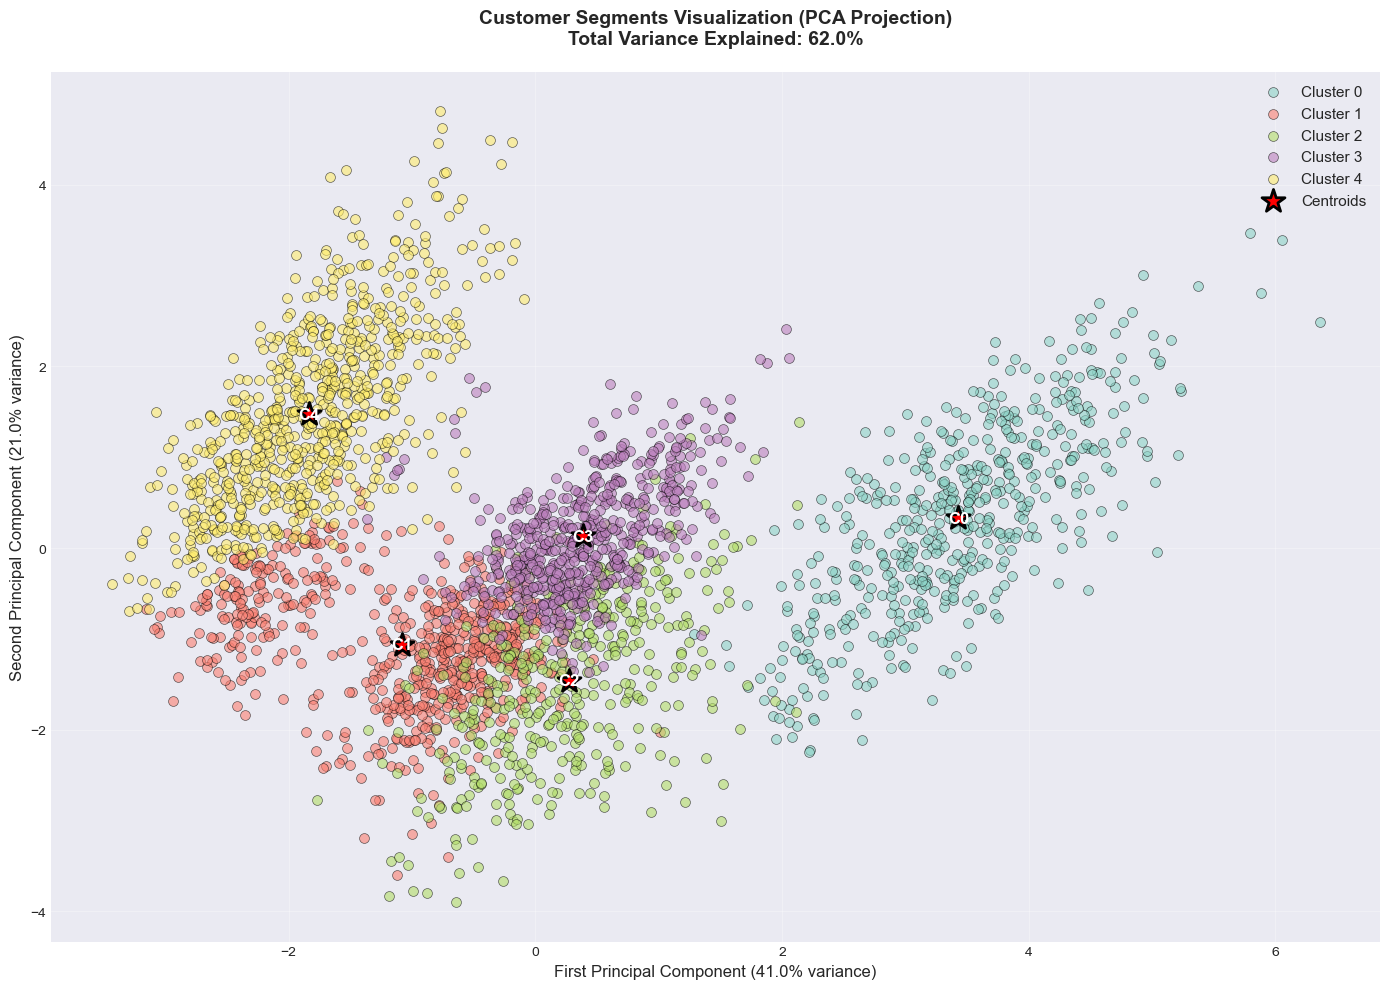

In [25]:
# Create PCA scatter plot
plt.figure(figsize=(14, 10))

colors = plt.cm.Set3(np.linspace(0, 1, optimal_k))

# Plot each cluster
for i in range(optimal_k):
    cluster_points = data_pca[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=[colors[i]], label=f'Cluster {i}',
                s=50, alpha=0.6, edgecolors='black', linewidth=0.5)

# Plot cluster centroids
centroids_pca = pca.transform(final_kmeans.cluster_centers_)
plt.scatter(centroids_pca[:, 0], centroids_pca[:, 1],
            c='red', s=300, alpha=1, edgecolors='black', linewidth=2,
            marker='*', label='Centroids')

# Add centroid labels
for i in range(optimal_k):
    plt.annotate(f'C{i}', 
                 xy=(centroids_pca[i, 0], centroids_pca[i, 1]),
                 fontsize=12, fontweight='bold', color='white',
                 ha='center', va='center')

plt.xlabel(f'First Principal Component ({variance_explained[0]:.1%} variance)', fontsize=12)
plt.ylabel(f'Second Principal Component ({variance_explained[1]:.1%} variance)', fontsize=12)
plt.title(f'Customer Segments Visualization (PCA Projection)\nTotal Variance Explained: {total_variance:.1%}', 
          fontsize=14, fontweight='bold', pad=20)
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Important Note on 2D Projection Limitations

**Understanding the Visualization:**

This 2D scatter plot is a **projection** of the actual 9-dimensional cluster space:

1. **Dimension Reduction:**
   - Original data: 9 behavioral dimensions
   - PCA projection: 2 dimensions for visualization
   - Information loss is inevitable

2. **What the Plot Shows:**
   - The first two principal components (linear combinations of original features)
   - Only captures ~XX% of total variance (shown above)
   - Clusters may appear to overlap due to dimension reduction

3. **What This Means:**
   - Clusters that overlap in 2D may be well-separated in 9D space
   - The actual clustering quality is measured by silhouette scores, not visual separation here
   - This plot is for general understanding, not validation

4. **Real Cluster Structure:**
   - Actual clusters exist in full 9-dimensional feature space
   - Distance calculations use all 9 dimensions
   - Cluster centroids are 9-dimensional points